In [1]:
import numpy as np
import os
import torch
import yaml
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
import cv2 as cv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from tqdm.auto import tqdm
import imageio
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter 


# 0.Info of Datasets
* Link:https://www.kaggle.com/datasets/ipythonx/carvana-image-masking-png

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Configs:
dataroot = config["dataroot"]
images=config['image_path']
masks=config['mask_path']
data_dim=config['data_dim']
split_ratio=config['split_ratio']
batch_size=config['batch_size']
epochs=config['epochs']
UN_encoder=config['U-net']['encoder']
UN_bn=config['U-net']['bottleneck']
UN_decoder=config['U-net']['decoder']
lr=config['Train_step']['lr']
in_channels=config['U-net']['in_channels']
out_channels=config['U-net']['out_channels']
device=config['Train_step']['device']
criterion=config['Train_step']['criterion']
optimizer=config['Train_step']['optimizer']


In [3]:
images_path=dataroot+images
masks_path=dataroot+masks  
len(os.listdir(images_path)),len(os.listdir(masks_path))

(5088, 5088)

# 1.Make a Datasets 
## 1.1 Class
`MakeDataset(Datasets)`
* 1.1 `__init__`
  * `image_path`: str
  * `masks_path`: str
  * `transform`: any
* 1.2 `__len__`
  * `return` Length of images datasets
* 1.3 `__getitem__`
  * `index`: int
  * `return` Image and Mask after processed

**Announcement**:
* `image` data shape is `torch.size[3,256,256]` and type is `tensor`
* `mask` data shape is `torch.size[1,256,256]` and type is `tensor`

In [4]:
class MakeDataset(Dataset):
    def __init__(self,images_path,masks_path,transform=None):
        self.images_path=images_path
        self.masks_path=masks_path
        self.transform=transform

        self.images_names=sorted(os.listdir(images_path))
        self.masks_names=sorted(os.listdir(masks_path))
    
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, index):
        image_path=os.path.join(self.images_path,self.images_names[index])

        mask_path=os.path.join(self.masks_path,self.masks_names[index])

        image=cv.imread(image_path)

        gif_reader=imageio.get_reader(mask_path)
        
        single_image=gif_reader.get_data(0)

        mask=cv.cvtColor(single_image,cv.COLOR_RGB2BGR)

        mask=mask[:,:,0]

        mask[mask==255.0]=1.0

        image=(image).astype('float32')

        mask=(mask).astype('float32')

        if (self.transform):
            augmented=self.transform(image=image,mask=mask)
            image=augmented['image']
            mask=augmented['mask']
        
        width=data_dim['width']
        height=data_dim['height']
        dimensions=(width,height)

        image=cv.resize(image,dimensions,interpolation=cv.INTER_AREA)
        mask=cv.resize(mask,dimensions,interpolation=cv.INTER_AREA)

        image=transforms.ToTensor()(image)
        mask=transforms.ToTensor()(mask)

        return image,mask






## 1.2 Split

In [5]:
dataset=MakeDataset(images_path=images_path,masks_path=masks_path)

In [6]:
split=random_split(dataset,[split_ratio,1-split_ratio])

In [7]:
train_dataloader=DataLoader(split[0],batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(split[1],batch_size=batch_size,shuffle=True)


## 1.3 Visualization

torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


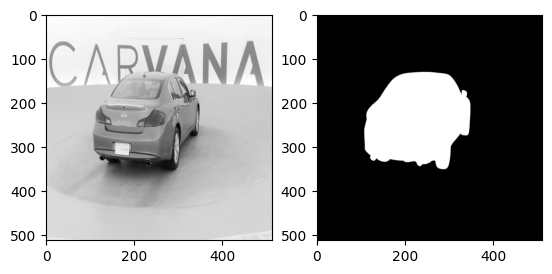

In [8]:
train_features_batch,train_labels_batch=next(iter(train_dataloader))

print(train_features_batch.shape,train_labels_batch.shape)
plt.subplot(1,2,1)
plt.imshow(train_features_batch[0,0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_labels_batch[0,0],cmap='gray')

# 2.DoubleConv
## 2.1 Class
* `__init__`
  * `in_channels`: int
  * `out_channels`: int
* `block`:
  * `nn.Conv2d`(in_channels,out_channels,k=3,s=1,p=1,bias=False)
  * `nn.BatchNorm2d`(out_channels)
  * `nn.ReLU`(inplece=True)
  * `nn.Conv2d`(in_channels,out_channels,k=3,s=1,p=1,bias=False)
  * `nn.BatchNorm2d`(out_channels)
  * `nn.ReLU`(inplece=True)
  

In [9]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.block=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.block(x)
    

## 2.2 Function `copy_and_crop`
* down_layer: 
    Element in `nn.ModuleList`
* up_layer: 
    Element in `nn.ModuleList`
* `T.CenterCrop`: 
  A function for cropping data from `down_layer` with specific size,which corresponding size of `up_layer`

In [10]:
def copy_and_crop(down_layer,up_layer):
    b,ch,h,w=up_layer.shape
    crop=T.CenterCrop((h,w))(down_layer)
    return crop

# 3.U-net architecture
## 3.1 Class
* `__init__`
  * `encoder`:`nn.ModuleList`
    * `DoubleConv`(in_channels,64)
    * `DoubleConv`(64,128)
    * `DoubleConv`(128,256)
    * `DoubleConv`(256,512)
  * `pool`:`nn.MaxPool2d`(k=2,s=2)
  * `bottle_neck`:`DoubleConv`(512,1024)
  * `up_samples`:`nn.ModuleList`
    * `nn.ConvTranspose2d`(1024,512,k=2,s=2)
    * `nn.ConvTranspose2d`(512,256,k=2,s=2)
    * `nn.ConvTranspose2d`(256,128,k=2,s=2)
    * `nn.ConvTranspose2d`(128,64,k=2,s=2)
  * `decoder`:`nn.ModuleList`
    * `DoubleConv`(1024,512)
    * `DoubleConv`(512,256)
    * `DoubleConv`(256,128)
    * `DoubleConv`(128,64)
  * `final_layer`:`nn.Conv2d`(64,out_channels,k=1,s=1)
* `forward`
  * Encoder:
    * layer in `encoder`
    * append into `skip_connection`:list
    * `pool`  
  * Bottle_neck:
    * layer in `bottle_neck`
  * Decoder:
    *  layer in `up_samples`
    *  `copy_and_crop` data from two layers `skip_connection` and `up_samples`
    *  Concatenation
    *  layer in `decoder`
  * Final_layer:
    * layer in `final_layer` 

In [11]:
class UNet(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(UNet,self).__init__()

        self.encoder=nn.ModuleList([
            DoubleConv(in_channels,UN_encoder['E1']),
            DoubleConv(UN_encoder['E1'],UN_encoder['E2']),
            DoubleConv(UN_encoder['E2'],UN_encoder['E3']),
            DoubleConv(UN_encoder['E3'],UN_encoder['E4'])
        ])
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.bottle_neck=DoubleConv(UN_encoder['E4'],UN_bn)

        self.up_samples=nn.ModuleList([
            nn.ConvTranspose2d(UN_bn,UN_encoder['E4'],kernel_size=2,stride=2),
            nn.ConvTranspose2d(UN_encoder['E4'],UN_encoder['E3'],kernel_size=2,stride=2),
            nn.ConvTranspose2d(UN_encoder['E3'],UN_encoder['E2'],kernel_size=2,stride=2),
            nn.ConvTranspose2d(UN_encoder['E2'],UN_encoder['E1'],kernel_size=2,stride=2)
        ])

        self.decoder=nn.ModuleList([
            DoubleConv(UN_bn,UN_decoder['D1']),
            DoubleConv(UN_decoder['D1'],UN_decoder['D2']),
            DoubleConv(UN_decoder['D2'],UN_decoder['D3']),
            DoubleConv(UN_decoder['D3'],UN_decoder['D4'])
        ])

        self.final_layer=nn.Conv2d(UN_decoder['D4'],out_channels,1,1)
    def forward(self,x):
        skip_connections=[]

        for layer in self.encoder:
            x=layer(x)
            skip_connections.append(x)
            x=self.pool(x)
        
        x=self.bottle_neck(x)

        for ind,layer in enumerate(self.decoder):
            x=self.up_samples[ind](x)
            y=copy_and_crop(skip_connections.pop(),x)
            x=layer(torch.cat([y,x],dim=1))

        x=self.final_layer(x)

        return x

## 3.2 Accuracy function Sørensen–Dice coefficient
* The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. 
* Wiki Link:https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
$$
\frac{2*|X\cap Y|}{|X|+|Y|}
$$
where $X$ is the predicted set of pixels and $Y$ is the ground truth. The Dice coefficient is defined to be 1 when both $X$ and $Y$ are empty. The leaderboard score is the mean of the Dice coefficients for each image in the test set.
* `dice_score`
  * `preds`:Results from U-Net model
  * `targets`:Ground truth
  

In [12]:
def dice_score(preds,targets):
    preds=F.sigmoid(preds)
    preds=(preds>0.5).float()
    score=(2.*(preds*targets).sum())/(preds+targets).sum()
    return torch.mean(score).item()


# 4.Train and validation

## 4.1 Configuration

In [14]:
unet_model=UNet(in_channels,out_channels).to(device)
if torch.cuda.device_count()>1:
    unet_model=nn.DataParallel(unet_model,device_ids=[i for i in range(torch.cuda.device_count())])

loss_cls=getattr(nn,criterion)
loss_fn=loss_cls()
Optimizer=getattr(optim,optimizer)(params=unet_model.parameters(),lr=lr)



## 4.2 Training

In [16]:

for epoch in tqdm(range(epochs)):
    dice=0
    val_dice=0
    for batch,(x,y) in tqdm(enumerate(train_dataloader)):
        unet_model.train()
        x=x.to(device)
        y=y.to(device)

        y_pred=unet_model(x).to(device)

        score=dice_score(y_pred,y)
        loss=loss_fn(y_pred,y)
        dice+=score

        Optimizer.zero_grad()
        
        loss.backward()

        Optimizer.step()

    unet_model.eval()
    print("Train Finished | Processing to test")
    with torch.inference_mode():
        for (x_val,y_val) in test_dataloader:
            x_val=x_val.to(device)
            y_val=y_val.to(device)
            y_val_pred=unet_model(x_val)
            val_dice+=dice_score(y_val_pred,y_val)
    
    dice/=(len(train_dataloader))
    val_dice/=len(test_dataloader)

    print(f'Epoch:{epoch+1} | Train Dice Score:{dice} | Val Dice Score={val_dice}')

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

## 4.3 Validation

In [ ]:
with torch.inference_mode():
    x_test,y_test=next(iter(test_dataloader))
    x_test=x_test.to(device)
    y_pred=unet_model(x_test)
    y_pred=torch.nn.functional.sigmoid(y_pred)
    x_test=x_test.to('cpu').numpy()
    y_test=y_test.numpy()
    y_pred=y_pred.to('cpu').numpy()
    

In [ ]:
axs_1=plt.subplot(1,2,1)
axs_1.set_title('Mask')
axs_1.imshow(y_test[3,0],cmap='gray')
axs_2=plt.subplot(1,2,2)
axs_2.set_title('Pred')
axs_2.imshow(y_pred[3,0],cmap='gray')
